<img src='./img/c3s_header.png' align='right' width='100%'></img>

<br>

# CMIP6: Global climate projections

### About

This notebook provides a practical introduction on how to access and process [CMIP6 global climate projections](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview) data available on the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S). The workflow shows you how to compute and visualize the output of an ensemble of models for the annual global average temperature from 1850 to 2100. You will use the `historical` experiment for the temporal period 1850 to 2014 and the three scenarios `SSP1-2.6`, `SSP2-4.5` and `SSP5-8.5` for the period from 2015 to 2100. 

For the sake of simiplicity, and to keep the volume of data small, the tutorial will make use of data from 8 models. However, many more models are available on the CDS, and when calculating an ensemble of models, the more that are used the more reliable the output. See [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-Models,gridsandpressurelevels) a full list of models included in the CDS-CMIP6 dataset.

Learn [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-Experiments) more about CMIP6 experiments in the Copernicus Climate Data Store.


The notebook has the following outline:

* [1 - Request data from the CDS programmatically with the CDS API](#request_data_cmip6)
* [2 - Unzip the downloaded data files](#unzip)
* [3 - Load and prepare CMIP6 historical data](#load_prepare_historical)
* [4 - Load and prepare CMIP6 data for all models and experiments](#load_prepare_all)
* [5 - Visualize CMIP6 annual global average temperature from 1850 to 2100](#visualize_cmip6)

### Data

This notebook introduces you to [CMIP6 Global climate projections](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview). The datasets used in the notebook have the following specifications:

> **Data**: `CMIP6 global climate projections of near-surface air temperature` <br>
> **Experiments**: `Historical, SSP1-2.6, SSP2-4.5, SSP5-8.5` <br>
> **Models**: `8 models from LIST COUNTRIES` <br>
> **Temporal coverage**: `Feb 1850 to Dec 2014` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `zip`

### How to access the notebook

This tutorial is in the form of a Jupyter notebook (https://jupyter.org/). We encourage you to consult the Jupyter website and the many excellent tutorials that can, in just a few minutes, explain what Jupyter notebooks are and how they work.

You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions:

- **Kaggle**: [this link will directly open the notebook](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training/blob/dev/131_c3s_cmip6_global_climate_projections-CS-EDITED_v3.ipynb), ready to run or edit as you wish. To know more about Kaggle, or to create your own notebook from scratch, visit https://www.kaggle.com/code.
- **Binder**: [this is another option to run the notebook](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/dev?urlpath=lab/tree/131_c3s_cmip6_global_climate_projections-CS-EDITED_v3.ipynb). To find out more about Binder, visit https://mybinder.org/.
- **NBViewer**: [this will not run the notebook, but can render it nicely in case you just want to view it](https://nbviewer.jupyter.org/github/ecmwf-projects/copernicus-training/blob/dev/131_c3s_cmip6_global_climate_projections-CS-EDITED_v3.ipynb.ipynb).

If you would like to run this notebook in your own environment, we suggest you install Anaconda https://docs.anaconda.com/anaconda/install/, which contains most of the libraries you will need, in addition to Xarray http://xarray.pydata.org/en/stable/ for working with multidimensional data in netcdf files, and the ADS API (`pip install cdsapi`) for downloading data programatically from the ADS.

<hr>

### Install CDS API via pip

In [ ]:
!pip install cdsapi

### Load libraries

In [1]:
# General libs
import glob # Pathname pattern expansion
import os, sys
import zipfile # To extract zipfiles
import urllib3 
urllib3.disable_warnings() # Disable warnings for data download via API

# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

<hr>

## <a id='request_data_cmip6'></a> 1. Request data from the CDS programmatically with the CDS API

The first step is to request data from the Climate Data Store programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. Below, you have to replace the `#########` with your personal CDS key. Please find [here](https://cds.climate.copernicus.eu/api-how-to) your personal CDS key.

In [2]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################'

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [2]:
DATADIR = './cmip6/'

The next step is then to request the data with the help of the CDS API. Below, we loop though multiple data requests. These include data for different models and scenarios. It is not possible to specify multiple models in one data request as their spatial resolution varies.

We will download monthly aggregated data. These are disseminated as netcdf files within a zip archive.

In order to loop through the various experiments and models in our data requests, we will specify them as Python 'lists' here:

In [3]:
experiments = ['historical', 'ssp126', 'ssp245', 'ssp585']

In [4]:
models = ['hadgem3_gc31_ll', 'canesm5_canoe', 'inm_cm5_0', 'inm_cm4_8', 'ipsl_cm6a_lr', 
          'mcm_ua_1_0', 'miroc_es2l', 'mpi_esm1_2_lr', 'ukesm1_0_ll']

Now we can download the data for each model and experiment sequentially. We will do this separately for the various future scenarios and for the historical experiments, given that they refer to two different time periods.

In [60]:
# GLOBAL SSP

c = cdsapi.Client(url=URL, key=KEY)

for i in experiments[1:]:
    for j in models:
        c.retrieve(
            'projections-cmip6',
            {
                'format': 'zip',
                'temporal_resolution': 'monthly',
                'experiment': f'{i}',
                'level': 'single_levels',
                'variable': 'near_surface_air_temperature',
                'model': f'{j}',
                'date': '2015-01-01/2100-12-31',
            },
            f'{DATADIR}cmip6_monthly_2015-2100_{i}_{j}.zip')

2022-01-27 16:46:51,330 INFO Welcome to the CDS
2022-01-27 16:46:51,331 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2022-01-27 16:46:51,410 INFO Request is completed
2022-01-27 16:46:51,415 INFO Downloading https://download-0014.copernicus-climate.eu/cache-compute-0014/cache/data0/adaptor.esgf_wps.retrieve-1643296534.1634307-21944-15-173a4be3-9061-44b5-af11-35b12f3015f1.zip to ./cmip6_glob_zip/cmip6_monthly_2015-2100_ssp126_hadgem3_gc31_ll.zip (55.3M)
2022-01-27 16:47:04,435 INFO Download rate 4.3M/s                                                                      
2022-01-27 16:47:04,492 INFO Welcome to the CDS
2022-01-27 16:47:04,493 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2022-01-27 16:47:04,562 INFO Downloading https://download-0009.copernicus-climate.eu/cache-compute-0009/cache/data8/adaptor.esgf_wps.retrieve-1643296561.238619-31838-13-ef2201e2-3f7a-4d13-bd29-fddea53d9bab.zip 

2022-01-27 16:55:15,872 INFO Downloading https://download-0005.copernicus-climate.eu/cache-compute-0005/cache/data9/adaptor.esgf_wps.retrieve-1643297473.4537585-30957-6-8eddc1e3-d6cc-4545-82ea-04a87508a0a0.zip to ./cmip6_glob_zip/cmip6_monthly_2015-2100_ssp126_kiost_esm.zip (72.7M)
2022-01-27 16:55:33,729 INFO Download rate 4.1M/s                                                                      
2022-01-27 16:55:33,780 INFO Welcome to the CDS
2022-01-27 16:55:33,781 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2022-01-27 16:55:33,853 INFO Downloading https://download-0012.copernicus-climate.eu/cache-compute-0012/cache/data8/adaptor.esgf_wps.retrieve-1643297500.2260408-21353-11-096ea29b-cfa7-45f1-ba77-94b2bddcf1a4.zip to ./cmip6_glob_zip/cmip6_monthly_2015-2100_ssp126_miroc6.zip (71.3M)
2022-01-27 16:55:50,367 INFO Download rate 4.3M/s                                                                      
2022-01-27 16:55:50,458 INFO We

2022-01-27 17:00:53,594 INFO Download rate 3.9M/s                                                                      
2022-01-27 17:00:53,647 INFO Welcome to the CDS
2022-01-27 17:00:53,649 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2022-01-27 17:00:53,674 INFO Request is queued
2022-01-27 17:00:54,700 INFO Request is running
2022-01-27 17:01:07,052 INFO Request is completed
2022-01-27 17:01:07,054 INFO Downloading https://download-0010.copernicus-climate.eu/cache-compute-0010/cache/data7/adaptor.esgf_wps.retrieve-1643302860.161393-4170-21-8b9d903c-e80e-4ab8-b539-9f8b4bfde002.zip to ./cmip6_glob_zip/cmip6_monthly_2015-2100_ssp126_mpi_esm1_2_lr.zip (33.1M)
2022-01-27 17:01:14,920 INFO Download rate 4.2M/s                                                                      
2022-01-27 17:01:14,970 INFO Welcome to the CDS
2022-01-27 17:01:14,971 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6

2022-01-27 17:12:56,906 INFO Request is completed
2022-01-27 17:12:56,913 INFO Downloading https://download-0015.copernicus-climate.eu/cache-compute-0015/cache/data7/adaptor.esgf_wps.retrieve-1643303554.230075-19497-8-8cfa5d3d-b525-4aae-bb46-f07f7bb948f5.zip to ./cmip6_glob_zip/cmip6_monthly_2015-2100_ssp245_noresm2_mm.zip (120.4M)
2022-01-27 17:13:24,571 INFO Download rate 4.4M/s                                                                      
2022-01-27 17:13:24,624 INFO Welcome to the CDS
2022-01-27 17:13:24,626 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2022-01-27 17:13:24,655 INFO Request is queued
2022-01-27 17:13:25,681 INFO Request is running
2022-01-27 17:13:45,598 INFO Request is completed
2022-01-27 17:13:45,602 INFO Downloading https://download-0009.copernicus-climate.eu/cache-compute-0009/cache/data0/adaptor.esgf_wps.retrieve-1643303614.5098348-26262-12-335554a5-077a-4d73-8538-a409f1c900a4.zip to ./cmip6_glob_zip/cmip6

2022-01-27 17:30:25,042 INFO Request is running
2022-01-27 17:40:42,648 INFO Request is completed
2022-01-27 17:40:42,650 INFO Downloading https://download-0008.copernicus-climate.eu/cache-compute-0008/cache/data4/adaptor.esgf_wps.retrieve-1643305221.6219263-1375-10-109e136c-369b-4cd4-a5cc-7a42c6bfd610.zip to ./cmip6_glob_zip/cmip6_monthly_2015-2100_ssp245_noresm2_lm.zip (32.4M)
2022-01-27 17:40:49,987 INFO Download rate 4.4M/s                                                                      
2022-01-27 17:40:50,036 INFO Welcome to the CDS
2022-01-27 17:40:50,037 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2022-01-27 17:40:50,071 INFO Request is queued
2022-01-27 17:40:51,107 INFO Request is running
2022-01-27 17:41:03,436 INFO Request is completed
2022-01-27 17:41:03,438 INFO Downloading https://download-0008.copernicus-climate.eu/cache-compute-0008/cache/data8/adaptor.esgf_wps.retrieve-1643305256.9767296-1403-20-d144aeb4-515f-47a2-

2022-01-27 17:56:19,038 INFO Download rate 4.4M/s                                                                      
2022-01-27 17:56:19,088 INFO Welcome to the CDS
2022-01-27 17:56:19,090 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2022-01-27 17:56:19,125 INFO Request is queued
2022-01-27 17:56:20,153 INFO Request is running
2022-01-27 17:56:51,543 INFO Request is completed
2022-01-27 17:56:51,544 INFO Downloading https://download-0004.copernicus-climate.eu/cache-compute-0004/cache/data9/adaptor.esgf_wps.retrieve-1643306182.855587-18326-17-0606b4a3-f572-4dfb-90ab-fbeb8c008126.zip to ./cmip6_glob_zip/cmip6_monthly_2015-2100_ssp585_fio_esm_2_0.zip (164M)
2022-01-27 17:57:29,765 INFO Download rate 4.3M/s                                                                      
2022-01-27 17:57:29,808 INFO Welcome to the CDS
2022-01-27 17:57:29,810 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2

2022-01-27 18:05:37,737 INFO Request is completed
2022-01-27 18:05:37,739 INFO Downloading https://download-0010.copernicus-climate.eu/cache-compute-0010/cache/data7/adaptor.esgf_wps.retrieve-1643306715.4190488-3957-20-c8727495-4f9b-48a5-9e0f-c198c9b73a70.zip to ./cmip6_glob_zip/cmip6_monthly_2015-2100_ssp585_cnrm_esm2_1.zip (71.3M)
2022-01-27 18:05:55,960 INFO Download rate 3.9M/s                                                                      
2022-01-27 18:05:56,030 INFO Welcome to the CDS
2022-01-27 18:05:56,032 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2022-01-27 18:05:56,068 INFO Request is queued
2022-01-27 18:05:57,096 INFO Request is running
2022-01-27 18:07:11,263 INFO Request is completed
2022-01-27 18:07:11,264 INFO Downloading https://download-0011.copernicus-climate.eu/cache-compute-0011/cache/data1/adaptor.esgf_wps.retrieve-1643306769.1638076-28744-19-4d411087-ac9b-4d24-b4b9-2c778fafc11b.zip to ./cmip6_glob_zip/cmip

In [67]:
# GLOBAL HISTORICAL

c = cdsapi.Client(url=URL, key=KEY)

for j in models:
    c.retrieve(
        'projections-cmip6',
        {
            'format': 'zip',
            'temporal_resolution': 'monthly',
            'experiment': 'historical',
            'level': 'single_levels',
            'variable': 'near_surface_air_temperature',
            'model': f'{j}',
            'date': '1850-02-01/2014-12-31',
        },
        f'{DATADIR}cmip6_monthly_1850-2014_historical_{j}.zip')

2022-01-27 21:48:00,755 INFO Welcome to the CDS
2022-01-27 21:48:00,755 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip6
2022-01-27 21:48:00,783 INFO Request is queued
2022-01-27 21:48:01,810 INFO Request is running
2022-01-27 21:48:50,317 INFO Request is completed
2022-01-27 21:48:50,320 INFO Downloading https://download-0001.copernicus-climate.eu/cache-compute-0001/cache/data6/adaptor.esgf_wps.retrieve-1643320093.7471907-20684-9-b74fd00a-d4d9-42cd-9f1b-e97e86b461d0.zip to ./cmip6_glob_zip/cmip6_monthly_1850-2014_historical_ukesm1_0_ll.zip (102.4M)
2022-01-27 21:49:13,946 INFO Download rate 4.3M/s                                                                      


## <a id='unzip'></a>2. Unzip the downloaded data files

From the Copernicus Climate Data Store, CMIP6 data are available as `zip` archive. For this reason, before we can load any data, we have to unzip the zip files. Once you downloaded the four experiments `historical`, `SSP1-2.6`, `SSP2-4.5` and `SSP5-8.5` as seperate zip files, you can use the functions from the `zipfile` Python package to extract the content of a zip file. First, you construct a `ZipFile()` object and second, you apply the function `extractall()` to extract the content of the zip file.

Below, the same process is repeated for all zip files. You see that the actual data files are disseminated in `NetCDF`.

First we create a list of the zipfiles:

In [8]:
cmip6_zip = list()
cmip6_zip_paths = glob.glob(f'{DATADIR}*.zip')
for i in cmip6_zip_paths:
    cmip6_zip.append(os.path.basename(i))

Then we extract each of the listed zipfiles:

In [ ]:
for j in cmip6_zip:
    with zipfile.ZipFile(f'{DATADIR}{j}', 'r') as zip_ref:
        zip_ref.extractall(f'{DATADIR}')

Here we list all the extracted NetCDF files in a single list.

In [5]:
# List
cmip6_nc = list()
cmip6_monthly_nc_rel = glob.glob(f'{DATADIR}tas*.nc')
for i in cmip6_monthly_nc_rel:
    cmip6_nc.append(os.path.basename(i))

## <a id='load_prepare_historical'></a>3. Load and prepare CMIP6 data for one model and one experiment

This example will show you how to prepare CMIP6 data for one model and one experiment. This process will then be repeated for multiple models and experiments to create a graph of annual global average temperature from a model ensemble. 

We begin by loading the first of the NetCDF files in our list. We will use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_dataset` to read NetCDF files.

The result is a `xarray.Dataset` object with four dimensions: `bnds`, `lat`, `lon`, `time`, of which the dimension `bnds` is not callable.

In [6]:
ds = xr.open_dataset(f'{DATADIR}{cmip6_nc[0]}')
ds

<xarray.Dataset>
Dimensions:    (time: 1979, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 1850-02-15 00:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/53)
    CCCma_model_hash:            932b659de600c6a0e94f619abaf9cc79eabcd337
    CCCma_parent_runid:          canoecpl-007
    CCCma_pycmor_hash:           3ecdc18eb7c1f7fbce0346850f41adf815d9fb66
    CCCma_runid:                 c2-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/48904243-28e8-4ccf-b987-feb3fe6...
    variable_id:                 tas
    variant_label:               r1i1p2f1
    version:                     v20190429
    license:                     CMIP6 model data produced by The Government ...
    cmor_version:                3.5.0

By examining the data above, we can see from the temporal range (1850 to 2014) that it is from the `historical` experiment.

We see that the data dimensions have been given labled coordinates of time, latitude and longitude. We can find more about the dataset from the `Attributes`, such information includes the model name, description of the variable (`long_name`), units, etc.

Some of this information we will need later, this includes the experiment and model IDs. We will save these into variables:

In [7]:
exp = ds.attrs['experiment_id']
mod = ds.attrs['source_id']

An `xarray.Dataset()` may contain arrays of multiple variables. We only have one variable in the dataset, which is Near-Surface Air Temperature, `tas`. Below we create an `xarray.DataArray()` object, which takes only one variable, but gives us more flexibility in processing.

In [8]:
da = ds['tas']

The next step is to aggregate the temperature values spatially and compute the global monthly near-surface temperature. 
To do this, the first step is to compute an overall weighted mean for the global near-surface air temperature for the reference period. You can compute the overall weighted mean of the data array object `tas_historical_global` in two steps:
1. `Calculating the weights`: for a regular latitude/longitude grid, the cosine of the latitude can be used as proxy for the grid cell area.
2. `Creating the average over latitude and longitude dimensions`: by applying the function `mean()` to the two dimensions `['longitude', 'latitude]`, we can compute the weighted global air temperature. 

In [9]:
weights = np.cos(np.deg2rad(da.lat))
weights.name = "weights"
da_weighted = da.weighted(weights)

The second step is then to compute the mean across the latitude and longitude dimensions of the weighted data array (`tas_historical_weighted`) with the function `mean()`. The result is a DataArray with one dimension (`time`) and 1979 entries. Please note, this operations leads to a drop of all attribute information.

In [10]:
da_agg = da_weighted.mean(['lat', 'lon'])

The next step is then to aggregate the monthly global near-surface air temperature values to annual global near-surface air temperature values. This operation can be done in two steps: first, all the values for one specific year have to be grouped with the function `groupby()` and second, you can create the average of each group with the function `mean()`.

The result is a one-dimensional DataArray with 165 entries. Please note that this operation changes the name of the dimension from `time` to `year`.

In [11]:
da_yr = da_agg.groupby('time.year').mean()

The metadata told us that the near-surface air temperature data values are in units of Kelvin. We will convert the to degrees Celsius by subtracting 273.15 from the data values. 

In [12]:
da_yr = da_yr - 273.15

Finally, we will create additional dimensions for the model and for the experiment. These we will label with the model and experiment name as taken from the metadata (see above). These will be useful when we repeat the processes above for all models and experiments, and combine them into one array.

In [13]:
da_yr = da_yr.assign_coords(model=mod)
da_yr = da_yr.expand_dims('model')
da_yr = da_yr.assign_coords(experiment=exp)
da_yr = da_yr.expand_dims('experiment')

## <a id='load_prepare_all'></a>4. Load and prepare CMIP6 data for all models and experiments

To repeat the steps above for all models and all experiments, we will collect all of the commands we have used so far into a function, which we can then apply to a batch of files corresponding to the data from all models and experiments.

In [14]:
# Function to aggregate in geographical lat lon dimensions

def geog_agg(fn):
    ds = xr.open_dataset(f'{DATADIR}{fn}')
    exp = ds.attrs['experiment_id']
    mod = ds.attrs['source_id']
    da = ds['tas']
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"
    da_weighted = da.weighted(weights)
    da_agg = da_weighted.mean(['lat', 'lon'])
    da_yr = da_agg.groupby('time.year').mean()
    da_yr = da_yr - 273.15
    da_yr = da_yr.assign_coords(model=mod)
    da_yr = da_yr.expand_dims('model')
    da_yr = da_yr.assign_coords(experiment=exp)
    da_yr = da_yr.expand_dims('experiment')
    da_yr.to_netcdf(path=f'{DATADIR}cmip6_agg_{exp}_{mod}_{str(da_yr.year[0].values)}.nc')

Now we can apply this function to all the extracted NetCDF files, taking care to record and skip any files which fail to be processed.

In [40]:
for i in cmip6_nc:
    try:
        geog_agg(i)
    except: print(f'{i} failed')

tas_Amon_CanESM5-CanOE_historical_r1i1p2f1_gn_18500215-20141216_v20190429.nc failed
tas_Amon_MCM-UA-1-0_historical_r1i1p1f2_gn_18500215-20141217_v20190731.nc failed
tas_Amon_MCM-UA-1-0_ssp126_r1i1p1f2_gn_201501-210012_v20190731.nc failed
tas_Amon_MCM-UA-1-0_ssp245_r1i1p1f2_gn_201501-210012_v20190731.nc failed
tas_Amon_MCM-UA-1-0_ssp585_r1i1p1f2_gn_201501-210012_v20190731.nc failed


We will now combine these processed files into one dataset for the final steps to create a visualisation of near-surface air temperature from the model ensemble.

We first create a list of the paths of the processed files:

In [15]:
cmip6_agg_nc_rel = glob.glob(f'{DATADIR}cmip6_agg*.nc')

We then combine all processed files into a single dataset. If all files have the same coordinates, the function `xarray.open_mfdataset` will merge the data according to the same coordinates.

In [19]:
# Using xarray.open_mfdataset

data_ds = xr.open_mfdataset(cmip6_agg_nc_rel)

The dataset created by `xarray.open_mfdataset` is by default a the form of "lazy Dask arrays", which are not in-memory "eager" arrays. For more details, see https://xarray.pydata.org/en/stable/user-guide/dask.html. To facilitate further processing we would need to convert these Dask arrays into in-memory arrays, which we can do by using the `load()` method: 

In [26]:
data_ds.load()

<xarray.Dataset>
Dimensions:     (year: 251, model: 8, experiment: 4)
Coordinates:
  * year        (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
    height      (model) float64 2.0 1.5 2.0 2.0 2.0 2.0 2.0 1.5
  * model       (model) object 'CanESM5-CanOE' ... 'UKESM1-0-LL'
  * experiment  (experiment) object 'historical' 'ssp126' 'ssp245' 'ssp585'
Data variables:
    tas         (experiment, model, year) float64 13.65 13.39 ... 20.48 20.63

Finally, we create an Xarray DataArray object for the Near-Surface Air Temperature variable, 'tas':

In [27]:
data = data_ds['tas']

## <a id='visualize_cmip6'></a>5. Visualize the CMIP6 annual global average temperature from 1850 to 2100

We will now create a plot of the model ensemble of near-surface air temperature for the historical and future periods, according to the three selected scenarios.

### Model ensemble calculation

Rather than plotting the data from all models, we will instead view the range of values as given by quantiles, including the 10th (near to lower limit), the 50th (mid-range) and 90th (near to upper limit) quantiles:

In [112]:
data_90 = data.quantile(0.9, dim='model')
data_10 = data.quantile(0.1, dim='model')
data_50 = data.quantile(0.5, dim='model')

C:\Users\cxcs\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Finally we will visualise this data in one time-series plot. We will use the matplotlib function `plot()`. The dimension year will be the x-axis and the near-surface air temperature values in degrees Celsius as the y-axis. 

The plotting function below has four main parts:
* **Initiate the plot**: initiate a matplotlib plot with `plt.subplots()`
* **Plot the time-series information**: plot the data for each experiment, including the historical experiment and three scenarios with the `plot()` function
* **Set axes limits, labels, title and legend**: Define title and axes labels, and add additional items to the plot, such as legend or gridlines

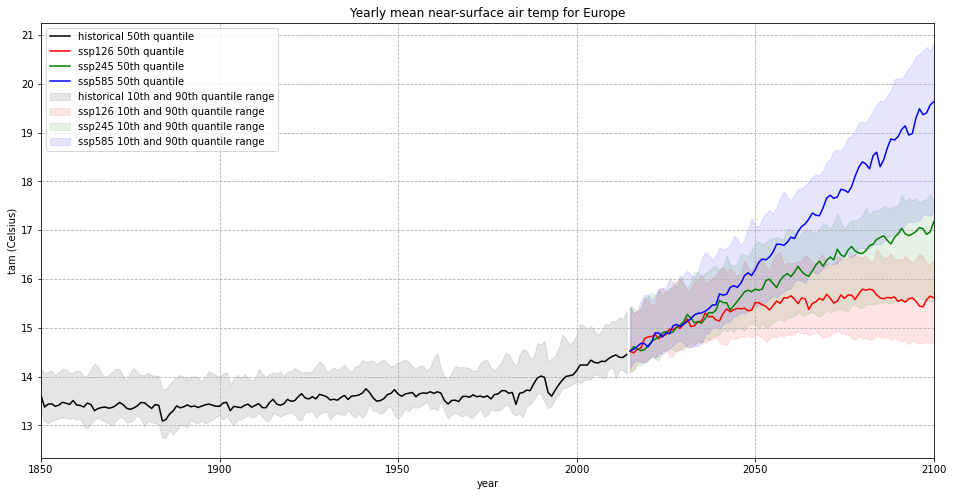

In [113]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

colours = ['black','red','green','blue']
for i in np.arange(len(experiments)):
    ax.plot(data_50.year, data_50[i,:], color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 50th quantile')
    ax.fill_between(data_50.year, data_90[i,:], data_10[i,:], alpha=0.1, color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 10th and 90th quantile range')

ax.set_xlim(1850,2100)
ax.set_title('Yearly mean near-surface air temp for Europe')
ax.set_ylabel('tam (Celsius)')
ax.set_xlabel('year')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

#fig.savefig('./AOD_NHem.png') # Save the figure

<br>

The visualization of the `CMIP6 annual global average temperature (1850 to 2100)` above shows that the global average temperature was more or less stable in the pre-industrial phase, but steadily increases since the 1990s. It further shows you that, depending on the SSP scenario, the course and increase of the global annual temperature differs fundamentally. While for the best case `SSP1-2.6` scenario, the global annual temperature could stabilize around 16 degC, for the worst case `SSP5-8.5` scenario, the global annual temperature could increase to above 20 degC.

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>